<a href="https://colab.research.google.com/github/VoroninMaxim/Actions_Docker/blob/main/%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BC%D0%B5%D1%82%D0%BA%D0%BE%D0%B2%D0%B0%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%81_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Dec 18 19:58:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os

import pandas as pd
pd.set_option('display.max_colwidth',0)
import numpy as np

from tqdm import tqdm
tqdm.pandas()

import gensim # что бы строить FastText

In [ ]:
data = pd.read_csv('/content/train.csv')

In [ ]:
data_v = pd.read_csv('/content/valid.csv')

In [ ]:
text_tokenized_1 = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

In [ ]:
%%time
model = gensim.models.FastText(
    [t.split() for t in text_tokenized_1], #корпус текстов разбитый по токенам
    min_count=1, #все слова даже те который встречались 1 раз
    negative=5, #негативных примеров
    window=5, #размер окна в алгоритме
    workers=12)#размер ядра на машине

CPU times: user 852 ms, sys: 657 ms, total: 1.51 s
Wall time: 1.51 s


In [ ]:
# Функция для вычисления наиболее подходящего слова для каждой строки
def find_best_word(row, model):
    vector_sum = np.zeros(model.vector_size)
    for emotion in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']:
        if row[emotion] == 1:
            vector_sum += model.wv[emotion]


    if np.linalg.norm(vector_sum) == 0:
        return None, 0
    vector_norm = vector_sum / np.linalg.norm(vector_sum)
    similar_words = model.wv.most_similar([vector_norm], topn=1)
    if similar_words:
        best_word, similarity = similar_words[0]
        return best_word, similarity
    else:
        return None, 0

In [ ]:
# Применение функции к каждой строке
data[['best_word', 'similarity']] = pd.DataFrame(data.apply(
    lambda row: find_best_word(row, model), axis=1).tolist(), index=data.index)

In [ ]:
data_v[['best_word', 'similarity']] = pd.DataFrame(data_v.apply(
    lambda row: find_best_word(row, model), axis=1).tolist(), index=data_v.index)

In [ ]:
data.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity
0,"Моя любимая еда — это все, что мне не приходилось готовить самому.",0,0,0,0,0,0,1,neutral,1.0
1,"Теперь, если он покончит с собой, все будут думать, что он смеется, трахая людей, а не на самом деле мертв.",0,0,0,0,0,0,1,neutral,1.0
2,КАКОГО НАХРАНА БЭЙЛЕССКАЯ ИЗОИНЦИЯ?,1,0,0,0,0,0,0,anger,1.0
3,Чтобы она почувствовала угрозу,0,0,1,0,0,0,0,fear,1.0
4,Грязные южные дрочники,1,0,0,0,0,0,0,anger,1.0


In [ ]:
data_v.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity
0,"Это в Новом Орлеане?? Я действительно чувствую, что это Новый Орлеан.",0,0,0,0,0,0,1,neutral,1.000000
1,"Ты знаешь ответ, чувак, ты запрограммирован перехватывать те коды, которые они тебе посылают, не избегай их!",0,0,0,1,0,0,1,joy,0.862076
2,Мне никогда в жизни не было так грустно!,0,0,0,0,1,0,0,sadness,1.000000
3,"Экономика находится под жестким контролем и субсидируется государством. В любом случае, я тыкал в отсутствии нюансов в сегодняшней политике США.",0,0,0,1,0,0,1,joy,0.862076
4,"Он мог бы легко взять настоящую камеру из законного источника, изменить цену в Word/Photoshop, а затем распечатать ее.",0,0,0,1,0,0,0,joy,1.000000


<Axes: xlabel='best_word', ylabel='count'>

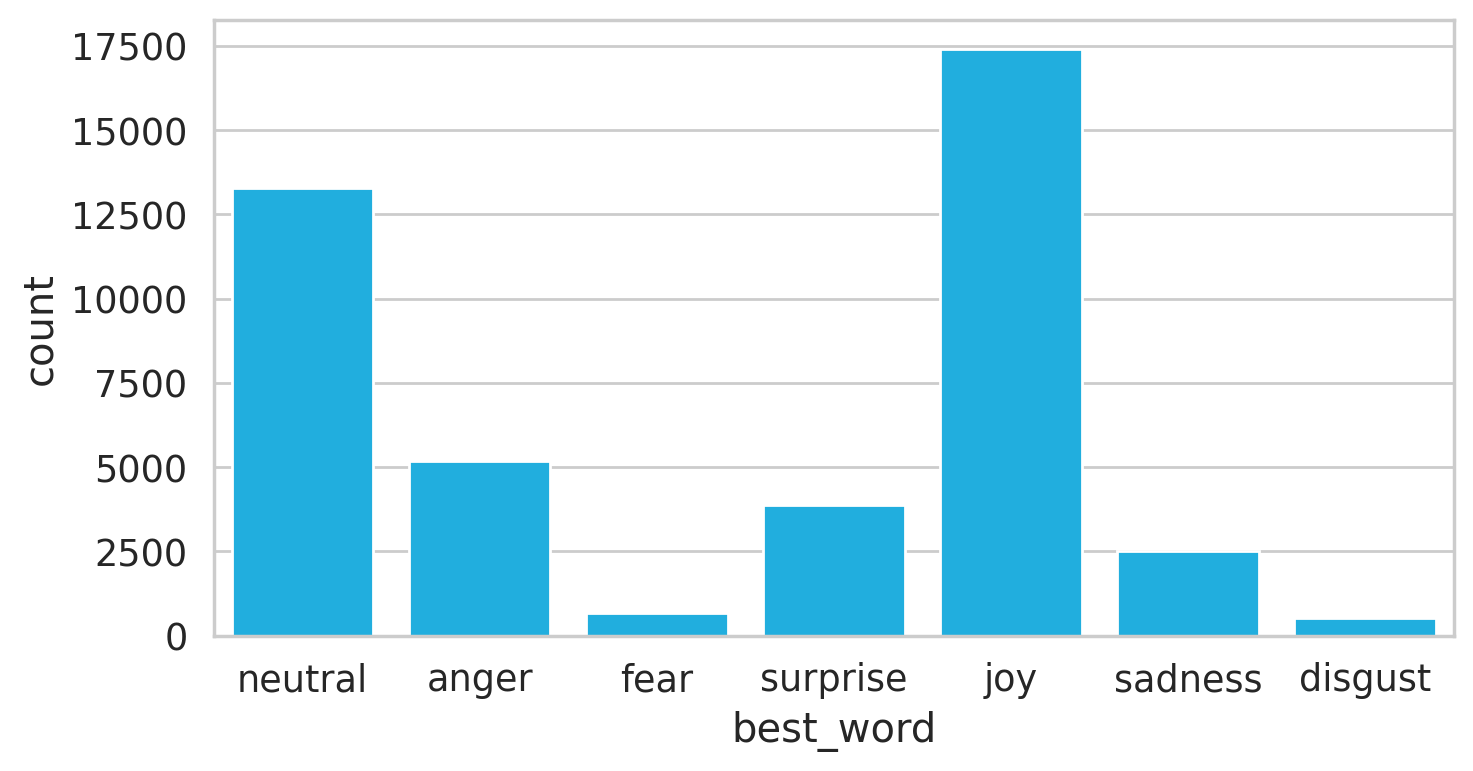

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(data=data, x='best_word')

# Предварительная обработка текста

In [ ]:
# !pip install spacy pymorphy3 networkx

In [ ]:
# !python -m spacy download ru_core_news_md

In [ ]:
import re
import pymorphy3
import string
import networkx as nx
from functools import lru_cache
from pymorphy3 import MorphAnalyzer
import spacy

# Загрузка модели для русского языка
nlp = spacy.load("ru_core_news_md")

# Инициализация морфологического анализатора
morph = pymorphy3.MorphAnalyzer()

In [ ]:
# Функция для нормализации текста
@lru_cache(1000000)# count words
def lemmatize(s):
    s = str(s).lower()
    return morph.parse(s)[0].normal_form

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
                                u"\U00000000-\U00000009"
                                u"\U0000000B-\U0000001F"
                                u"\U00000080-\U00000400"
                                u"\U00000402-\U0000040F"
                                u"\U00000450-\U00000450"
                                u"\U00000452-\U0010FFFF"
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002500-\U00002BEF"  # chinese char
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                u"\U0001f926-\U0001f937"
                                u"\U00010000-\U0010ffff"
                                u"\u2640-\u2642"
                                u"\u2600-\u2B55"
                                u"\u200d"
                                u"\u23cf"
                                u"\u23e9"
                                u"\u231a"
                                u"\ufe0f"  # dingbats
                                u"\u3030"

                                "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def clear_text(text):
    text = str(text).lower()
    text = text.replace('\n', ' ')# удаляем все переносы строк
    text = text.replace('.', '. ')# удаляем все переносы строк
    text = text.replace(',', ', ')# удаляем все переносы строк
    text = text.replace('xa0', ' ')# неразрывный пробез заменяем на пробел
    text = text.replace('\xa0', ' ')# неразрывный пробез заменяем на пробел

    # Преобразование токенов обратно в строку
    text = re.sub(r'\#', '', text)  # Удаление хэштегов
    text = re.sub(r'@', '', text)  # Удаление упоминаний (@)
    text = text.translate(str.maketrans("", "", string.punctuation))  # Удаление пунктуации

    text = re.sub("""[()""''«»—]""", ' ', text)
    text = re.sub("""[\.![]]-[-_,?:;]""", ' ', text)
    text = re.sub(r"\[.*?\]", ' ', text)
    text = re.sub("""\d+""", ' ', text) # Удалить лишние numbers
    text = re.sub('\s+', ' ', text) # Удалить лишние пробелы из текста

    return text.strip()

In [ ]:
# Основная функция для предобработки текста
def preprocess_text(text):
    text = lemmatize(text)
    text = deEmojify(text)
    text = clear_text(text)

    return text

In [ ]:
data['clean'] = data['text'].progress_apply(preprocess_text)

100%|██████████| 43410/43410 [00:14<00:00, 3086.09it/s]


In [ ]:
data_v['clean'] = data_v['text'].progress_apply(preprocess_text)

100%|██████████| 5426/5426 [00:01<00:00, 3513.29it/s]


In [ ]:
data.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean
0,"Моя любимая еда — это все, что мне не приходилось готовить самому.",0,0,0,0,0,0,1,neutral,1.0,моя любимая еда это все что мне не приходилось готовить самому
1,"Теперь, если он покончит с собой, все будут думать, что он смеется, трахая людей, а не на самом деле мертв.",0,0,0,0,0,0,1,neutral,1.0,теперь если он покончит с собой все будут думать что он смеется трахая людей а не на самом деле мертв
2,КАКОГО НАХРАНА БЭЙЛЕССКАЯ ИЗОИНЦИЯ?,1,0,0,0,0,0,0,anger,1.0,какого нахрана бэйлесская изоинция
3,Чтобы она почувствовала угрозу,0,0,1,0,0,0,0,fear,1.0,чтобы она почувствовала угроза
4,Грязные южные дрочники,1,0,0,0,0,0,0,anger,1.0,грязные южные дрочник


In [ ]:
data_v.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean
0,"Это в Новом Орлеане?? Я действительно чувствую, что это Новый Орлеан.",0,0,0,0,0,0,1,neutral,1.000000,это в новом орлеане я действительно чувствую что это новый орлеан
1,"Ты знаешь ответ, чувак, ты запрограммирован перехватывать те коды, которые они тебе посылают, не избегай их!",0,0,0,1,0,0,1,joy,0.862076,ты знаешь ответ чувак ты запрограммирован перехватывать те коды которые они тебе посылают не избегай их
2,Мне никогда в жизни не было так грустно!,0,0,0,0,1,0,0,sadness,1.000000,мне никогда в жизни не было так грустно
3,"Экономика находится под жестким контролем и субсидируется государством. В любом случае, я тыкал в отсутствии нюансов в сегодняшней политике США.",0,0,0,1,0,0,1,joy,0.862076,экономика находится под жестким контролем и субсидируется государством в любом случае я тыкал в отсутствии нюансов в сегодняшней политике сша
4,"Он мог бы легко взять настоящую камеру из законного источника, изменить цену в Word/Photoshop, а затем распечатать ее.",0,0,0,1,0,0,0,joy,1.000000,он мог бы легко взять настоящую камеру из законного источника изменить цену в wordphotoshop а затем распечатать ее


### удаления ненужных слов - 1

In [ ]:
# Список ненужных слов
unwanted_words = ['лола', 'человек', 'дело', 'вид', 'ребёнок', 'знать', 'ваш', 'говорить', 'чтоть', 'твой', 'парень', 'день', 'ребёнок', 'ум', 'школа', 'юуууууууууп', 'бог']

# Функция для удаления ненужных слов из текста
def remove_unwanted_words(text, unwanted_words):
    words = text.split()
    filtered_words = [word for word in words if word not in unwanted_words]
    return ' '.join(filtered_words)

In [ ]:
# Применяем функцию к каждой строке в колонке 'text_column'
data['clean'] = data['clean'].apply(lambda x: remove_unwanted_words(x, unwanted_words))

In [ ]:
# Применяем функцию к каждой строке в колонке 'text_column'
data_v['clean'] = data_v['clean'].apply(lambda x: remove_unwanted_words(x, unwanted_words))

### удаления ненужных слов - 2

In [ ]:
# Определяем путь к файлу со стоп-словами явно
file_path = '/content/stopwords-ru.txt'

In [ ]:
# Проверка существования файла
if os.path.exists(file_path):
    with open(file_path, 'r', encoding='utf-8') as _f:
        _stop_words = _f.read()
    # Разбиваем текст на строки и удаляем пустые строки и строки с пробелами
    _stop_words = set(line.strip() for line in _stop_words.split('\n') if line.strip())
else:
    print(f"Файл {file_path} не найден.")
    _stop_words = set()

In [ ]:
# По умолчанию n=3, что означает, что функция вернет 5 самых важных слов из текста, определенных на основе их PageRank.
def get_keywords(text, n=3):

    global _stop_words  # Убедимся, что _stop_words доступна внутри функции
    # Обработка текста
    doc = nlp(text)

    # Лемматизация слов и удаление стоп-слов
    words = [lemmatize(token.text) for token in doc if not token.is_stop and token.is_alpha and token.text not in _stop_words]

    # Создание графа слов
    graph = nx.Graph()
    for word in words:
        graph.add_node(word)

    # Добавление ребер между словами, которые находятся рядом
    for i in range(len(words) - 1):
        graph.add_edge(words[i], words[i + 1])

    # Вычисление PageRank
    pagerank = nx.pagerank(graph)

    # Сортировка слов по PageRank
    sorted_words = sorted(pagerank, key=pagerank.get, reverse=True)

    # Возвращаем ключевые слова в виде строки
    return ' '.join(sorted_words[:n])

In [ ]:
data['sentences'] = data['clean'].progress_apply(get_keywords)

100%|██████████| 43410/43410 [12:23<00:00, 58.40it/s]


In [ ]:
data_v['sentences'] = data_v['clean'].progress_apply(get_keywords)

100%|██████████| 5426/5426 [01:34<00:00, 57.30it/s]


In [ ]:
data.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean,sentences
0,"Моя любимая еда — это все, что мне не приходилось готовить самому.",0,0,0,0,0,0,1,neutral,1.0,моя любимая еда это все что мне не приходилось готовить самому,приходиться любимый готовить
1,"Теперь, если он покончит с собой, все будут думать, что он смеется, трахая людей, а не на самом деле мертв.",0,0,0,0,0,0,1,neutral,1.0,теперь если он покончит с собой все будут думать что он смеется трахая людей а не на самом деле мертв,смеяться дело трахать
2,КАКОГО НАХРАНА БЭЙЛЕССКАЯ ИЗОИНЦИЯ?,1,0,0,0,0,0,0,anger,1.0,какого нахрана бэйлесская изоинция,бэйлесский нахрана изоинция
3,Чтобы она почувствовала угрозу,0,0,1,0,0,0,0,fear,1.0,чтобы она почувствовала угроза,почувствовать угроза
4,Грязные южные дрочники,1,0,0,0,0,0,0,anger,1.0,грязные южные дрочник,южный грязный дрочник


In [ ]:
data_v.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean,sentences
0,"Это в Новом Орлеане?? Я действительно чувствую, что это Новый Орлеан.",0,0,0,0,0,0,1,neutral,1.000000,это в новом орлеане я действительно чувствую что это новый орлеан,орлеан новый чувствовать
1,"Ты знаешь ответ, чувак, ты запрограммирован перехватывать те коды, которые они тебе посылают, не избегай их!",0,0,0,1,0,0,1,joy,0.862076,ты знаешь ответ чувак ты запрограммирован перехватывать те коды которые они тебе посылают не избегай их,ответ посылать запрограммировать
2,Мне никогда в жизни не было так грустно!,0,0,0,0,1,0,0,sadness,1.000000,мне никогда в жизни не было так грустно,жизнь грустно
3,"Экономика находится под жестким контролем и субсидируется государством. В любом случае, я тыкал в отсутствии нюансов в сегодняшней политике США.",0,0,0,1,0,0,1,joy,0.862076,экономика находится под жестким контролем и субсидируется государством в любом случае я тыкал в отсутствии нюансов в сегодняшней политике сша,находиться политика жёсткий
4,"Он мог бы легко взять настоящую камеру из законного источника, изменить цену в Word/Photoshop, а затем распечатать ее.",0,0,0,1,0,0,0,joy,1.000000,он мог бы легко взять настоящую камеру из законного источника изменить цену в wordphotoshop а затем распечатать ее,настоящий wordphotoshop камера


In [ ]:
all_words = ' '.join(word for word in data['sentences'])

In [ ]:
from wordcloud import WordCloud

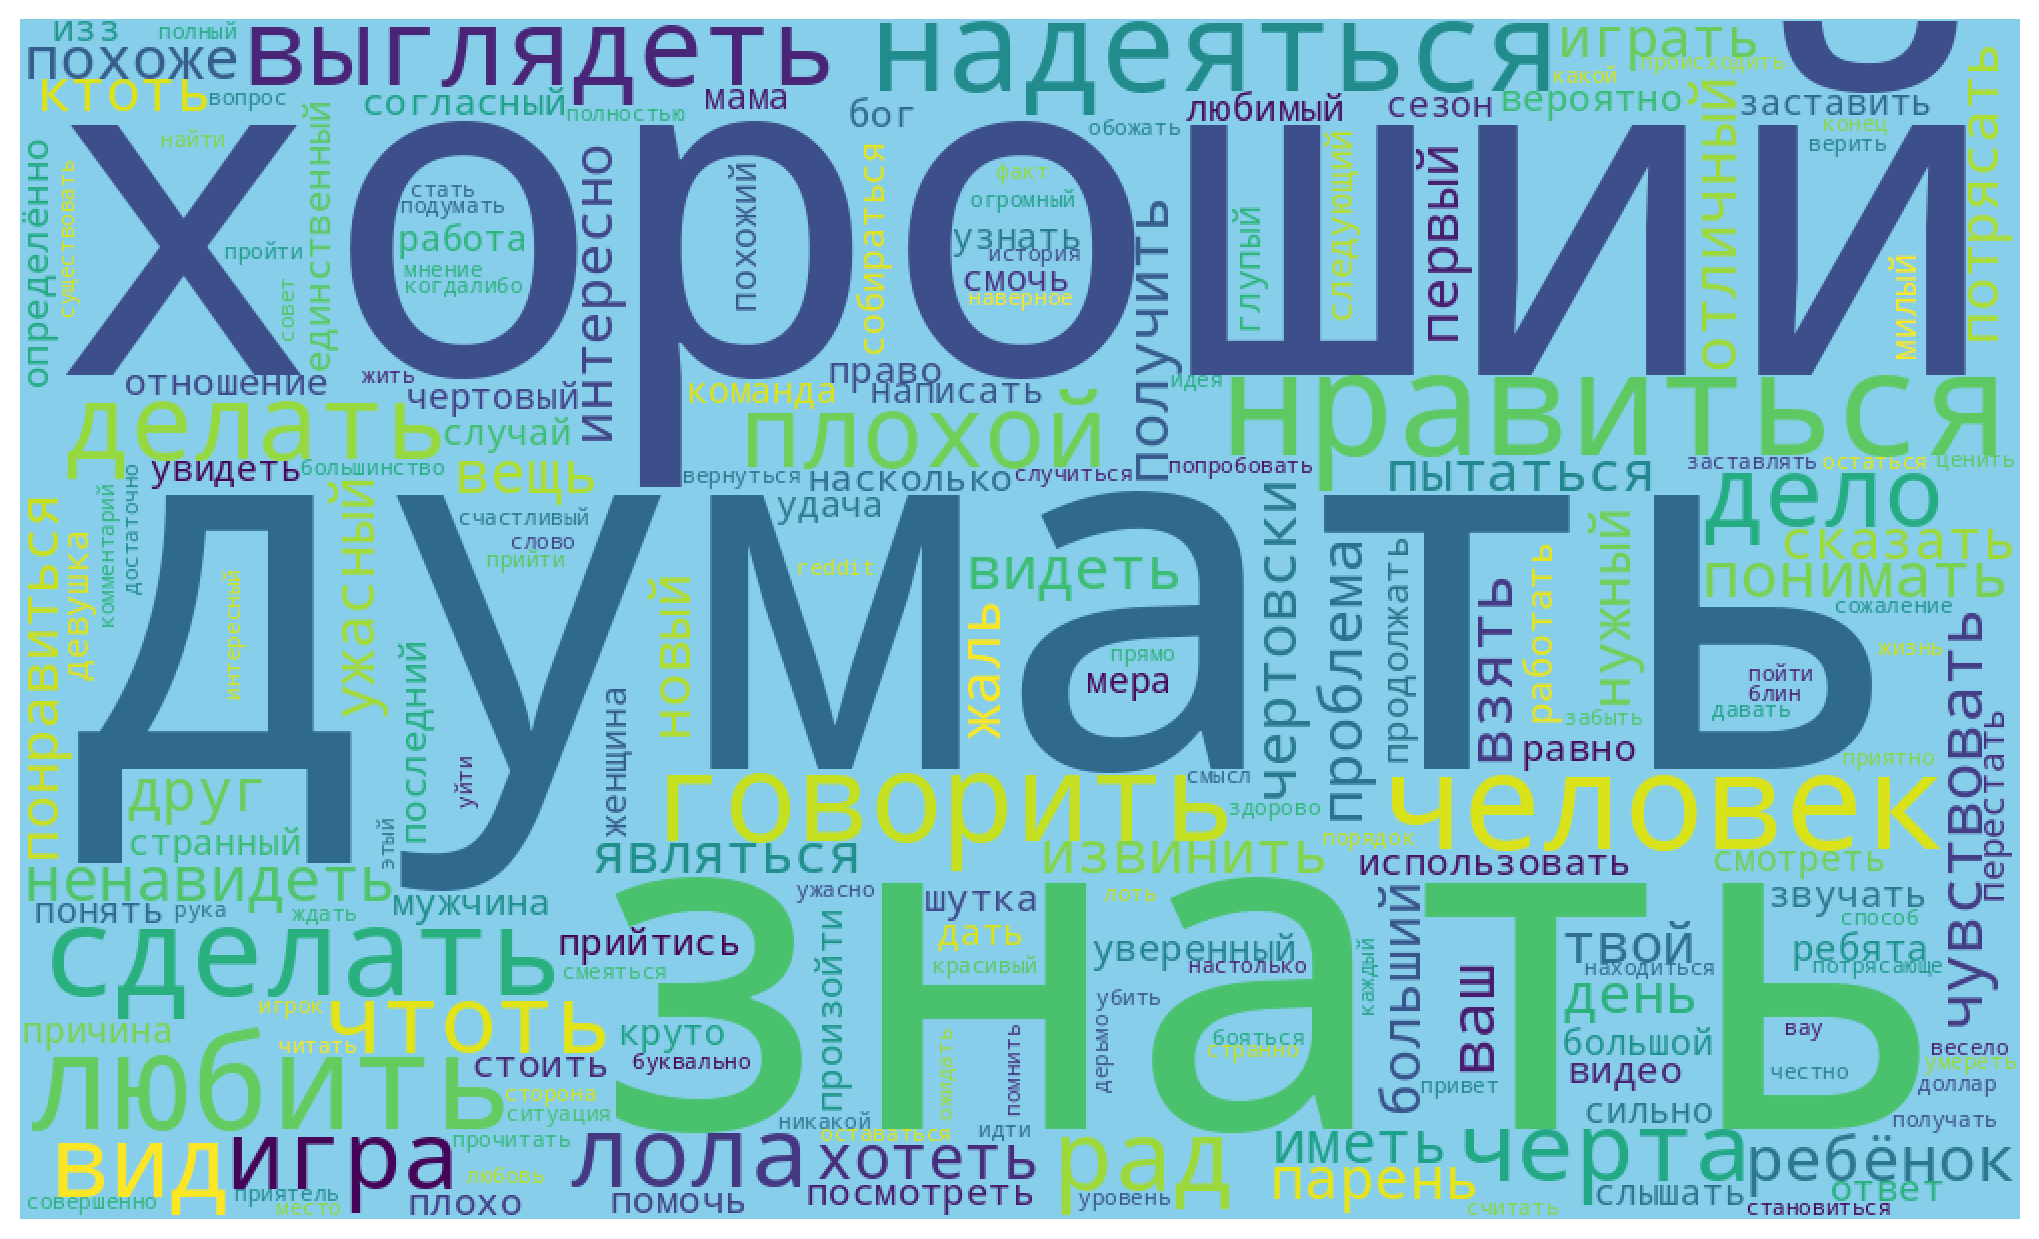

In [ ]:
wordcloud = WordCloud(
    width = 1000,
    height = 600,
    background_color = 'skyblue',
    min_font_size = 10).generate(all_words)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Удаление Пустых строк и дубликатов

In [ ]:
# Удаление строк с пустыми или короткими предложениями
data = data[data['sentences'].apply(lambda x: len(x.split()) >= 2)]

In [ ]:
# Проверка на наличие строк с менее чем одним словом или пустых строк
empty_or_short_sentences = data[data['sentences'].apply(lambda x: len(x.split()) <= 1)]
empty_or_short_sentences.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean,sentences


In [ ]:
# Удаление строк с пустыми или короткими предложениями
data_v = data_v[data_v['sentences'].apply(lambda x: len(x.split()) >= 2)]

In [ ]:
# Проверка на наличие строк с менее чем одним словом или пустых строк
empty_or_short_sentences_val = data_v[data_v['sentences'].apply(lambda x: len(x.split()) <= 1)]
empty_or_short_sentences_val.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean,sentences


In [ ]:
index = data[data.duplicated() == True].index
data.drop(index, axis=0, inplace=True)
data.reset_index(inplace=True, drop=True)

In [ ]:
index = data_v[data_v.duplicated() == True].index
data_v.drop(index, axis=0, inplace=True)
data_v.reset_index(inplace=True, drop=True)

In [ ]:
data = data.drop_duplicates(subset='sentences')

In [ ]:
data_v = data_v.drop_duplicates(subset='sentences')

In [ ]:
data.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean,sentences
0,"Моя любимая еда — это все, что мне не приходилось готовить самому.",0,0,0,0,0,0,1,neutral,1.0,моя любимая еда это все что мне не приходилось готовить самому,приходиться любимый готовить
1,"Теперь, если он покончит с собой, все будут думать, что он смеется, трахая людей, а не на самом деле мертв.",0,0,0,0,0,0,1,neutral,1.0,теперь если он покончит с собой все будут думать что он смеется трахая людей а не на самом деле мертв,смеяться дело трахать
2,КАКОГО НАХРАНА БЭЙЛЕССКАЯ ИЗОИНЦИЯ?,1,0,0,0,0,0,0,anger,1.0,какого нахрана бэйлесская изоинция,бэйлесский нахрана изоинция
3,Чтобы она почувствовала угрозу,0,0,1,0,0,0,0,fear,1.0,чтобы она почувствовала угроза,почувствовать угроза
4,Грязные южные дрочники,1,0,0,0,0,0,0,anger,1.0,грязные южные дрочник,южный грязный дрочник


In [ ]:
data_v.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean,sentences
0,"Это в Новом Орлеане?? Я действительно чувствую, что это Новый Орлеан.",0,0,0,0,0,0,1,neutral,1.000000,это в новом орлеане я действительно чувствую что это новый орлеан,орлеан новый чувствовать
1,"Ты знаешь ответ, чувак, ты запрограммирован перехватывать те коды, которые они тебе посылают, не избегай их!",0,0,0,1,0,0,1,joy,0.862076,ты знаешь ответ чувак ты запрограммирован перехватывать те коды которые они тебе посылают не избегай их,ответ посылать запрограммировать
2,Мне никогда в жизни не было так грустно!,0,0,0,0,1,0,0,sadness,1.000000,мне никогда в жизни не было так грустно,жизнь грустно
3,"Экономика находится под жестким контролем и субсидируется государством. В любом случае, я тыкал в отсутствии нюансов в сегодняшней политике США.",0,0,0,1,0,0,1,joy,0.862076,экономика находится под жестким контролем и субсидируется государством в любом случае я тыкал в отсутствии нюансов в сегодняшней политике сша,находиться политика жёсткий
4,"Он мог бы легко взять настоящую камеру из законного источника, изменить цену в Word/Photoshop, а затем распечатать ее.",0,0,0,1,0,0,0,joy,1.000000,он мог бы легко взять настоящую камеру из законного источника изменить цену в wordphotoshop а затем распечатать ее,настоящий wordphotoshop камера


# Несбалансированные данные

In [ ]:
data.best_word.value_counts()

,count
best_word,
joy,15311
neutral,11587
anger,4713
surprise,3445
sadness,2319
fear,605
disgust,469


In [ ]:
joy = 1300
neutral = 1300
anger = 1300
surprise = 1300
sadness = 1300
fear = 605
disgust = 469

In [ ]:
df_joy = data[data.best_word=="joy"].sample(joy, random_state=42)
df_neutral = data[data.best_word=="neutral"].sample(neutral, random_state=42)
df_anger = data[data.best_word=="anger"].sample(anger, random_state=42)
df_surprise = data[data.best_word=="surprise"].sample(surprise, random_state=42)
df_sadness =  data[data.best_word=="sadness"].sample(sadness, random_state=42)
df_fear =  data[data.best_word=="fear"].sample(fear, random_state=42)
df_disgust =  data[data.best_word=="disgust"].sample(disgust, random_state=42)

df_joy.shape, df_neutral.shape, df_anger.shape, df_surprise.shape, df_sadness.shape, df_fear.shape, df_disgust.shape

((1300, 12),
 (1300, 12),
 (1300, 12),
 (1300, 12),
 (1300, 12),
 (605, 12),
 (469, 12))

####  Генерируем похожие слова

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

In [ ]:
# Функция для генерации похожих слов
def generate_similar_words(sentence, morph):
    words = sentence.split()
    similar_words = set()
    for word in words:
        parsed_word = morph.parse(word)[0]
        forms = parsed_word.lexeme
        similar_words.update(form.word for form in forms)
    return ' '.join(similar_words)

In [ ]:
# Функция для вычисления косинусного сходства
def get_most_similar_words(sentence, similar_words, top_n=3):
    vectorizer = TfidfVectorizer().fit_transform([sentence] + similar_words.split())
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity([vectors[0]], vectors[1:])
    similar_indices = cosine_sim[0].argsort()[-top_n:][::-1]
    return ' '.join(similar_words.split()[i] for i in similar_indices)

In [ ]:
# Функция для извлечения одного предложения из 2 или 3 слов
def extract_sentence(similar_words):
    words = similar_words.split()
    if len(words) < 2:
        return similar_words
    combinations_2 = list(combinations(words, 2))
    combinations_3 = list(combinations(words, 3))
    if combinations_3:
        return ' '.join(combinations_3[0])
    elif combinations_2:
        return ' '.join(combinations_2[0])
    else:
        return similar_words

####  отвращение

In [ ]:
# Применяем функцию к каждой строке в колонке 'sentences' и добавляем результат в новую колонку 'similar_words'
df_disgust['similar_words'] = df_disgust['sentences'].apply(lambda x: generate_similar_words(x, morph))

In [ ]:
df_disgust['most_similar_words'] = df_disgust.apply(lambda row: get_most_similar_words(row['sentences'], row['similar_words']), axis=1)

In [ ]:
# Удаляем колонку 'similar_words' в первом DataFrame
df_disgust = df_disgust.drop(columns=['similar_words'])

In [ ]:
# Создаем два идентичных DataFrame
df_disgust_2 = df_disgust.copy()

In [ ]:
# Удаляем колонку 'similar_words' в первом DataFrame
df_disgust_2 = df_disgust_2.drop(columns=['sentences'])

df_disgust = df_disgust.drop(columns=['most_similar_words'])

In [ ]:
# Переименовываем колонку 'most_similar_words' в 'sentences' во втором DataFrame
df_disgust_2 = df_disgust_2.rename(columns={'most_similar_words': 'sentences'})

### страх

In [ ]:
# Применяем функцию к каждой строке в колонке 'sentences' и добавляем результат в новую колонку 'similar_words'
df_fear['similar_words'] = df_fear['sentences'].apply(lambda x: generate_similar_words(x, morph))

# Применяем функцию для извлечения предложений
df_fear['extracted_sentence'] = df_fear['similar_words'].apply(extract_sentence)

In [ ]:
# Удаляем колонку 'similar_words' в первом DataFrame
df_fear = df_fear.drop(columns=['similar_words'])

In [ ]:
# Создаем два идентичных DataFrame
df_fear_2 = df_fear.copy()

In [ ]:
# # Удаляем колонку 'similar_words' в первом DataFrame
df_fear_2 = df_fear_2.drop(columns=['sentences'])

df_fear = df_fear.drop(columns=['extracted_sentence'])

In [ ]:
# Переименовываем колонку 'most_similar_words' в 'sentences' во втором DataFrame
df_fear_2 = df_fear_2.rename(columns={'extracted_sentence': 'sentences'})

In [ ]:
df_balanced = pd.concat([df_joy,
                         df_neutral,
                         df_anger,
                         df_surprise,
                         df_sadness,
                         df_fear,
                         df_fear_2,
                         df_disgust,
                         df_disgust_2
                         ],axis=0)
df_balanced.best_word.value_counts()

,count
best_word,
joy,1300
neutral,1300
anger,1300
surprise,1300
sadness,1300
fear,1210
disgust,938


In [ ]:
# Удаление строк с пустыми или короткими предложениями
df_balanced = df_balanced[df_balanced['sentences'].apply(lambda x: len(x.split()) >= 2)]

In [ ]:
index = df_balanced[df_balanced.duplicated() == True].index
df_balanced.drop(index, axis=0, inplace=True)
df_balanced.reset_index(inplace=True, drop=True)

In [ ]:
# Удаление дублирующихся строк на основе столбца 'sentences'
df_balanced = df_balanced.drop_duplicates(subset='sentences')

In [ ]:
df_balanced.best_word.value_counts()

,count
best_word,
joy,1300
neutral,1300
anger,1300
surprise,1300
sadness,1300
fear,1157
disgust,790


In [ ]:
# Объединяем все датасеты в один для удаления
df_to_remove = pd.concat([df_joy, df_neutral, df_anger, df_surprise, df_sadness])

In [ ]:
# Удаляем строки из df_common, которые присутствуют в df_to_remove
df_balanced_2 = data[~data['text'].isin(df_to_remove['text'])]

In [ ]:
data_v.best_word.value_counts()

,count
best_word,
joy,1978
neutral,1442
anger,602
surprise,415
sadness,273
fear,79
disgust,59


In [ ]:
fear_v = 79
disgust_v = 59

df_fear_v = data_v[data_v.best_word=="fear"].sample(fear_v, random_state=42)
df_disgust_v =  data_v[data_v.best_word=="disgust"].sample(disgust_v, random_state=42)

In [ ]:
df_balanced_v = pd.concat([df_fear_v, df_disgust_v],axis=0)
df_balanced_v.best_word.value_counts()

,count
best_word,
fear,79
disgust,59


In [ ]:
data_balanced_1 = pd.concat([df_balanced, df_balanced_v],axis=0)
data_balanced_1.best_word.value_counts()

,count
best_word,
joy,1300
neutral,1300
anger,1300
surprise,1300
sadness,1300
fear,1236
disgust,849


In [ ]:
data_balanced_2 = pd.concat([df_balanced_2, data_v],axis=0)
data_balanced_2.best_word.value_counts()

,count
best_word,
joy,15989
neutral,11729
anger,4015
surprise,2560
sadness,1292
fear,684
disgust,528


In [ ]:
joy = 700
neutral = 700
anger = 700
surprise = 700
sadness = 700
fear = 684
disgust = 528

In [ ]:
df_joy = data_balanced_2[data_balanced_2.best_word=="joy"].sample(joy, random_state=42)
df_neutral = data_balanced_2[data_balanced_2.best_word=="neutral"].sample(neutral, random_state=42)
df_anger = data_balanced_2[data_balanced_2.best_word=="anger"].sample(anger, random_state=42)
df_surprise = data_balanced_2[data_balanced_2.best_word=="surprise"].sample(surprise, random_state=42)
df_sadness =  data_balanced_2[data_balanced_2.best_word=="sadness"].sample(sadness, random_state=42)
df_fear =  data_balanced_2[data_balanced_2.best_word=="fear"].sample(fear, random_state=42)
df_disgust =  data_balanced_2[data_balanced_2.best_word=="disgust"].sample(disgust, random_state=42)

In [ ]:
df_joy.shape, df_neutral.shape, df_anger.shape, df_surprise.shape, df_sadness.shape, df_fear.shape, df_disgust.shape

((700, 12), (700, 12), (700, 12), (700, 12), (700, 12), (684, 12), (528, 12))

In [ ]:
data_balanced_all_2 = pd.concat([df_joy, df_neutral, df_anger, df_surprise, df_sadness, df_fear, df_disgust],axis=0)
data_balanced_all_2.best_word.value_counts()

,count
best_word,
joy,700
neutral,700
anger,700
surprise,700
sadness,700
fear,684
disgust,528


In [ ]:
data_balanced_2 = data_balanced_all_2
data_balanced_2.best_word.value_counts()

,count
best_word,
joy,700
neutral,700
anger,700
surprise,700
sadness,700
fear,684
disgust,528


<Axes: xlabel='best_word', ylabel='count'>

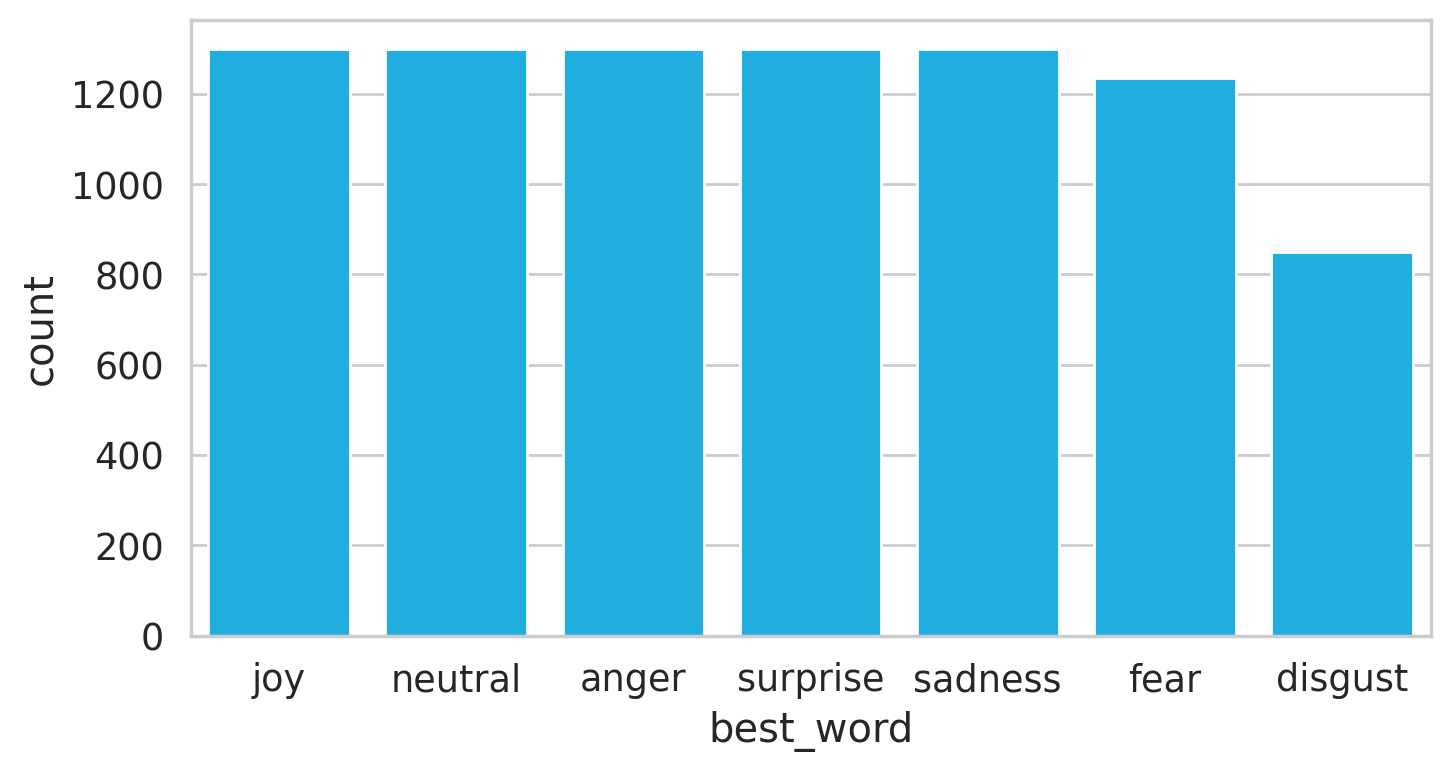

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data_balanced_1, x='best_word')

<Axes: xlabel='best_word', ylabel='count'>

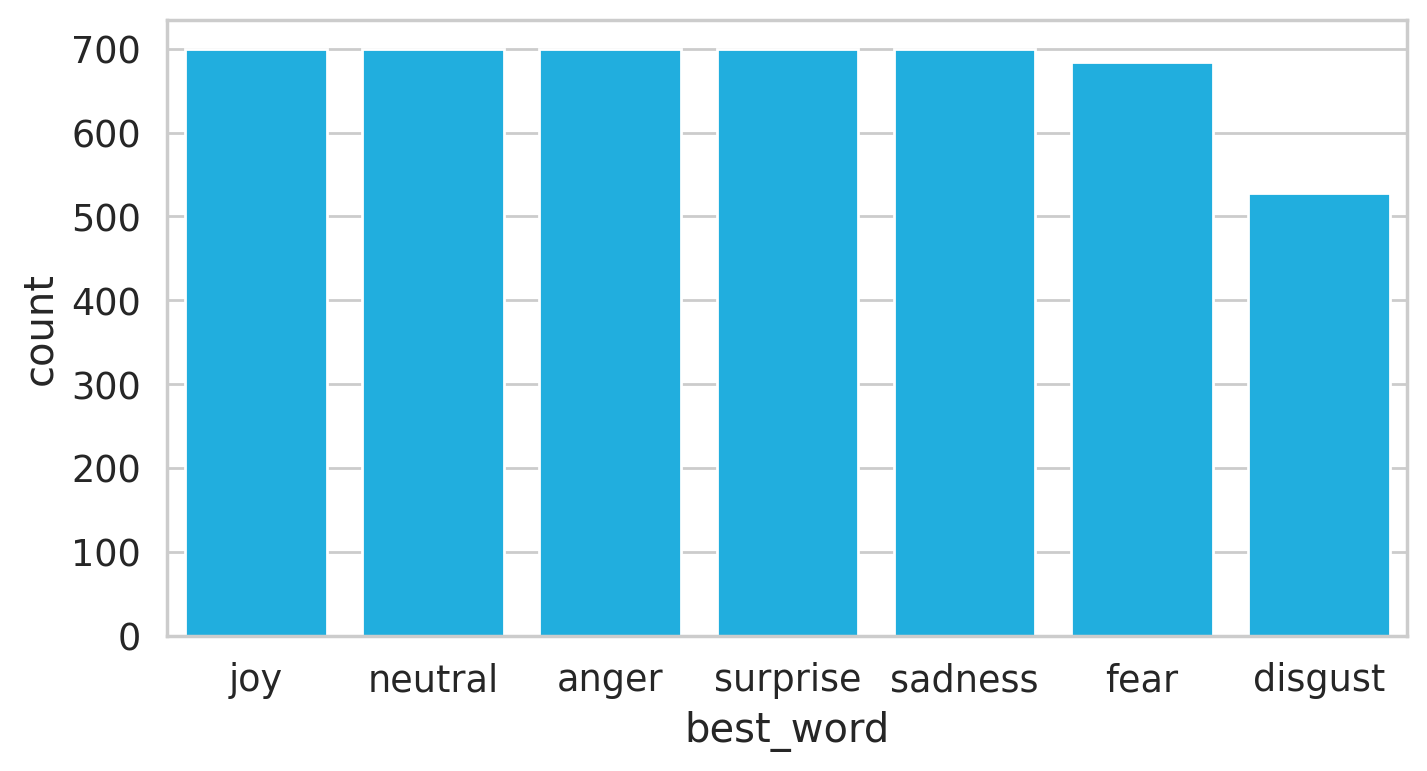

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data_balanced_2, x='best_word')

In [ ]:
X = np.array(data_balanced_1['sentences'])
y = np.array(data_balanced_1['best_word'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Transforming the sentiments to numbers
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Vectorizing the text column
vec = TfidfVectorizer()
X = vec.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.32      0.26      0.29       246
           1       0.76      0.75      0.76       158
           2       0.31      0.72      0.43       247
           3       0.49      0.39      0.43       274
           4       0.20      0.17      0.18       259
           5       0.46      0.28      0.35       275
           6       0.32      0.21      0.25       258

    accuracy                           0.37      1717
   macro avg       0.41      0.40      0.38      1717
weighted avg       0.39      0.37      0.36      1717



# Удаление лишник колонок

In [ ]:
empty_data_balanced_1 = data_balanced_1[data_balanced_1['sentences'].apply(lambda x: len(x.split()) <= 1)]
empty_data_balanced_1.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean,sentences


In [ ]:
# Удаление дублирующихся строк на основе столбца 'sentences'
data_balanced_1 = data_balanced_1.drop_duplicates(subset='sentences')

In [ ]:
empty_data_balanced_1 = data_balanced_2[data_balanced_2['sentences'].apply(lambda x: len(x.split()) <= 1)]
empty_data_balanced_1.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,best_word,similarity,clean,sentences


In [ ]:
# Удаление дублирующихся строк на основе столбца 'sentences'
data_balanced_2 = data_balanced_2.drop_duplicates(subset='sentences')

In [ ]:
data_balanced_1.drop(columns=['text', 'best_word', 'similarity', 'clean'], inplace=True)

data_balanced_2.drop(columns=['text', 'best_word', 'similarity', 'clean'], inplace=True)

<ipython-input-173-879eba35cc0d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_balanced_2.drop(columns=['text', 'best_word', 'similarity', 'clean'], inplace=True)


In [ ]:
data_balanced_1 = data_balanced_1.rename(columns={'sentences': 'text',
                            'anger': 'anger', 'disgust': 'disgust',
                            'fear': 'fear', 'joy': 'joy',
                            'sadness': 'sadness', 'surprise': 'surprise', 'neutral': 'neutral'})

In [ ]:
data_balanced_2 = data_balanced_2.rename(columns={'sentences': 'text',
                            'anger': 'anger', 'disgust': 'disgust',
                            'fear': 'fear', 'joy': 'joy',
                            'sadness': 'sadness', 'surprise': 'surprise', 'neutral': 'neutral'})

In [ ]:
data_balanced_1 = data_balanced_1.reindex(columns=['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'])

In [ ]:
data_balanced_2 = data_balanced_2.reindex(columns=['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'])

In [ ]:
columns_to_convert = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

In [ ]:
data_balanced_1[columns_to_convert] = data_balanced_1[columns_to_convert].astype(bool)

data_balanced_2[columns_to_convert] = data_balanced_2[columns_to_convert].astype(bool)

In [ ]:
data_balanced_1 = data_balanced_1.dropna(subset=['text'])
data_balanced_1.isnull().sum()

,0
text,0
anger,0
disgust,0
fear,0
joy,0
sadness,0
surprise,0
neutral,0


In [ ]:
data_balanced_2 = data_balanced_2.dropna(subset=['text'])
data_balanced_2.isnull().sum()

,0
text,0
anger,0
disgust,0
fear,0
joy,0
sadness,0
surprise,0
neutral,0


In [ ]:
data_balanced_1.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,продолжать удача дух,False,False,False,True,False,False,False
1,кататься зажигать гитара,False,False,False,True,False,False,False
2,слушать грустный,False,False,False,True,False,False,False
3,быстро согласиться странно,False,False,False,True,False,False,False
4,танк ацп причина,False,False,False,True,False,False,False


In [ ]:
data_balanced_2.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
4836,кавер вжиться любимый,False,False,False,True,False,False,False
31170,разместить помочь rphotoshop,False,False,False,True,False,False,False
469,глюк лола звук,False,False,False,True,False,False,False
4571,отредактировать часть отразить,False,False,False,True,False,False,False
20785,ваш уважать лень,False,False,False,True,False,False,False


In [ ]:
data_balanced_1.shape, data_balanced_2.shape

((8584, 8), (4710, 8))

In [ ]:
data_balanced_1.to_csv('data_balanced_train_sentiment_text.csv', index=False)

data_balanced_2.to_csv('data_balanced_train_sentiment_text_2.csv', index=False)

# Настройка модели DistilBertModel

In [ ]:
#!!pip install pytorch-lightning

In [ ]:
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertModel, DistilBertTokenizerFast, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl

# from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [ ]:
BERT_MODEL_NAME = 'DeepPavlov/distilrubert-small-cased-conversational'

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('DeepPavlov/distilrubert-small-cased-conversational')

In [ ]:
data_balans_1 = pd.read_csv('/content/data_balanced_train_sentiment_text.csv')
data_balans_1.shape

(8584, 8)

In [ ]:
data_balans_2 = pd.read_csv('/content/data_balanced_train_sentiment_text_2.csv')
data_balans_2.shape

(4710, 8)

In [ ]:
LABEL_COLUMNS = data_balans_1.columns.tolist()[1:]

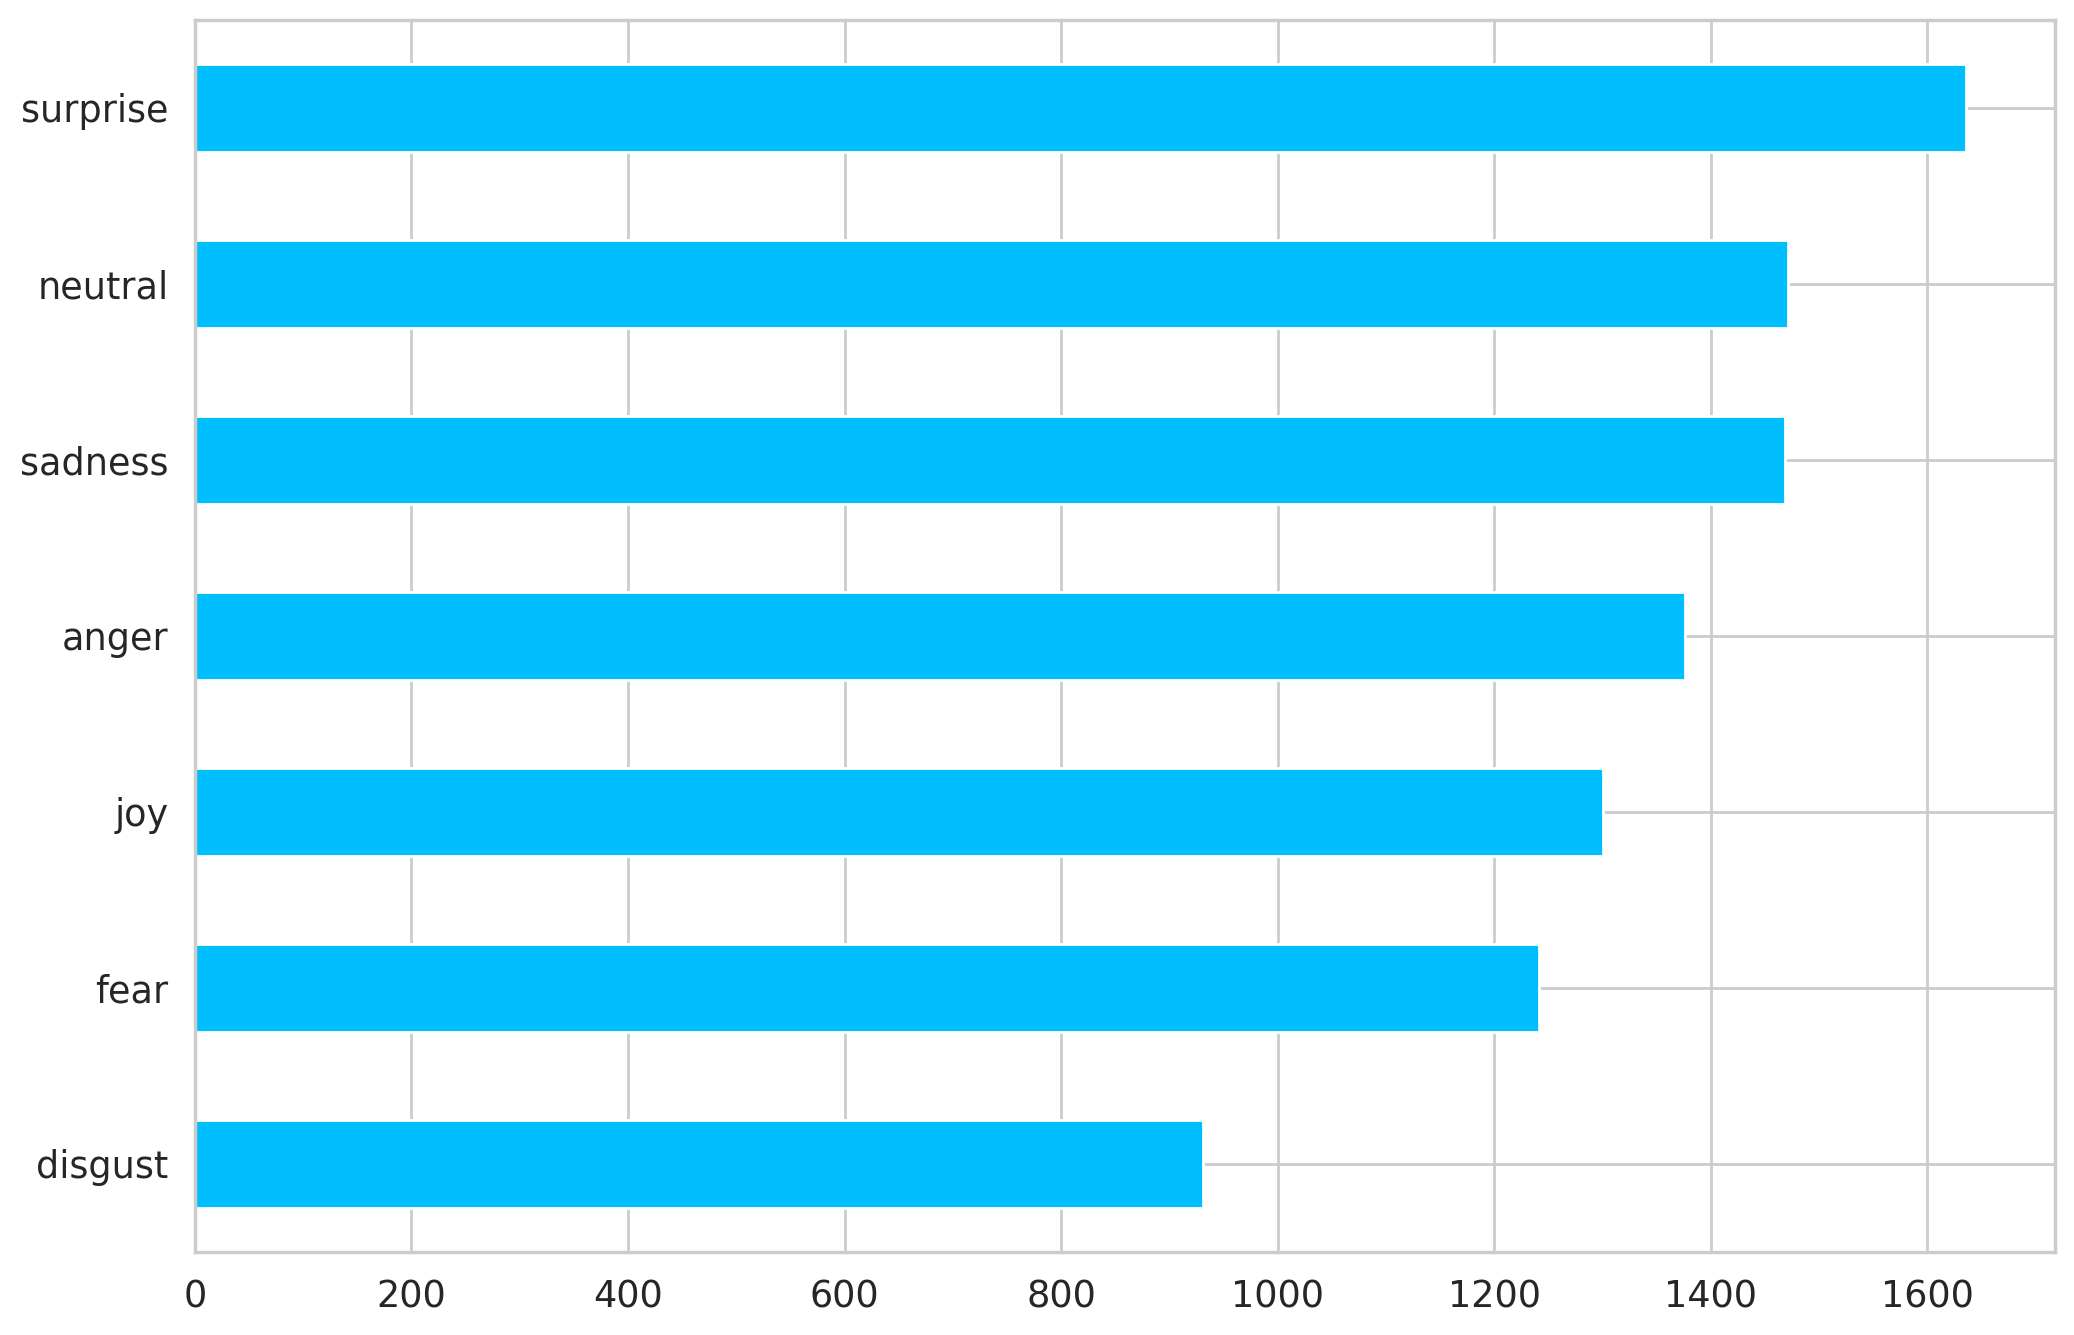

In [ ]:
data_balans_1[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [ ]:
# Пример набора данных
class CustomDataset(Dataset):

    def __init__(self, csv_file, tokenizer, max_length):
        self.dataset = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        review_text = self.dataset.iloc[idx, 0]  # Предполагая, что text — это первый столбец.
        assert isinstance(review_text, str), f"Expected review_text to be a string, but got {type(review_text)}"

        labels = self.dataset.iloc[idx, 1:]  # Предполагая, что эмоции начинаются со второго столбца.

        # Проверка на пустые значения и пропуски
        if pd.isnull(review_text) or review_text.strip() == "":
            raise ValueError(f"Empty or null value found in review_text at index {idx}")
        if labels.isnull().any():
            raise ValueError(f"Null values found in labels at index {idx}")


        encoding = self.tokenizer.encode_plus(
            review_text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'review_text': review_text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

In [ ]:
bert_model = DistilBertModel.from_pretrained('DeepPavlov/distilrubert-small-cased-conversational', return_dict=True)

In [ ]:
MAX_TOKEN_COUNT = 16

In [ ]:
BATCH_SIZE = 64

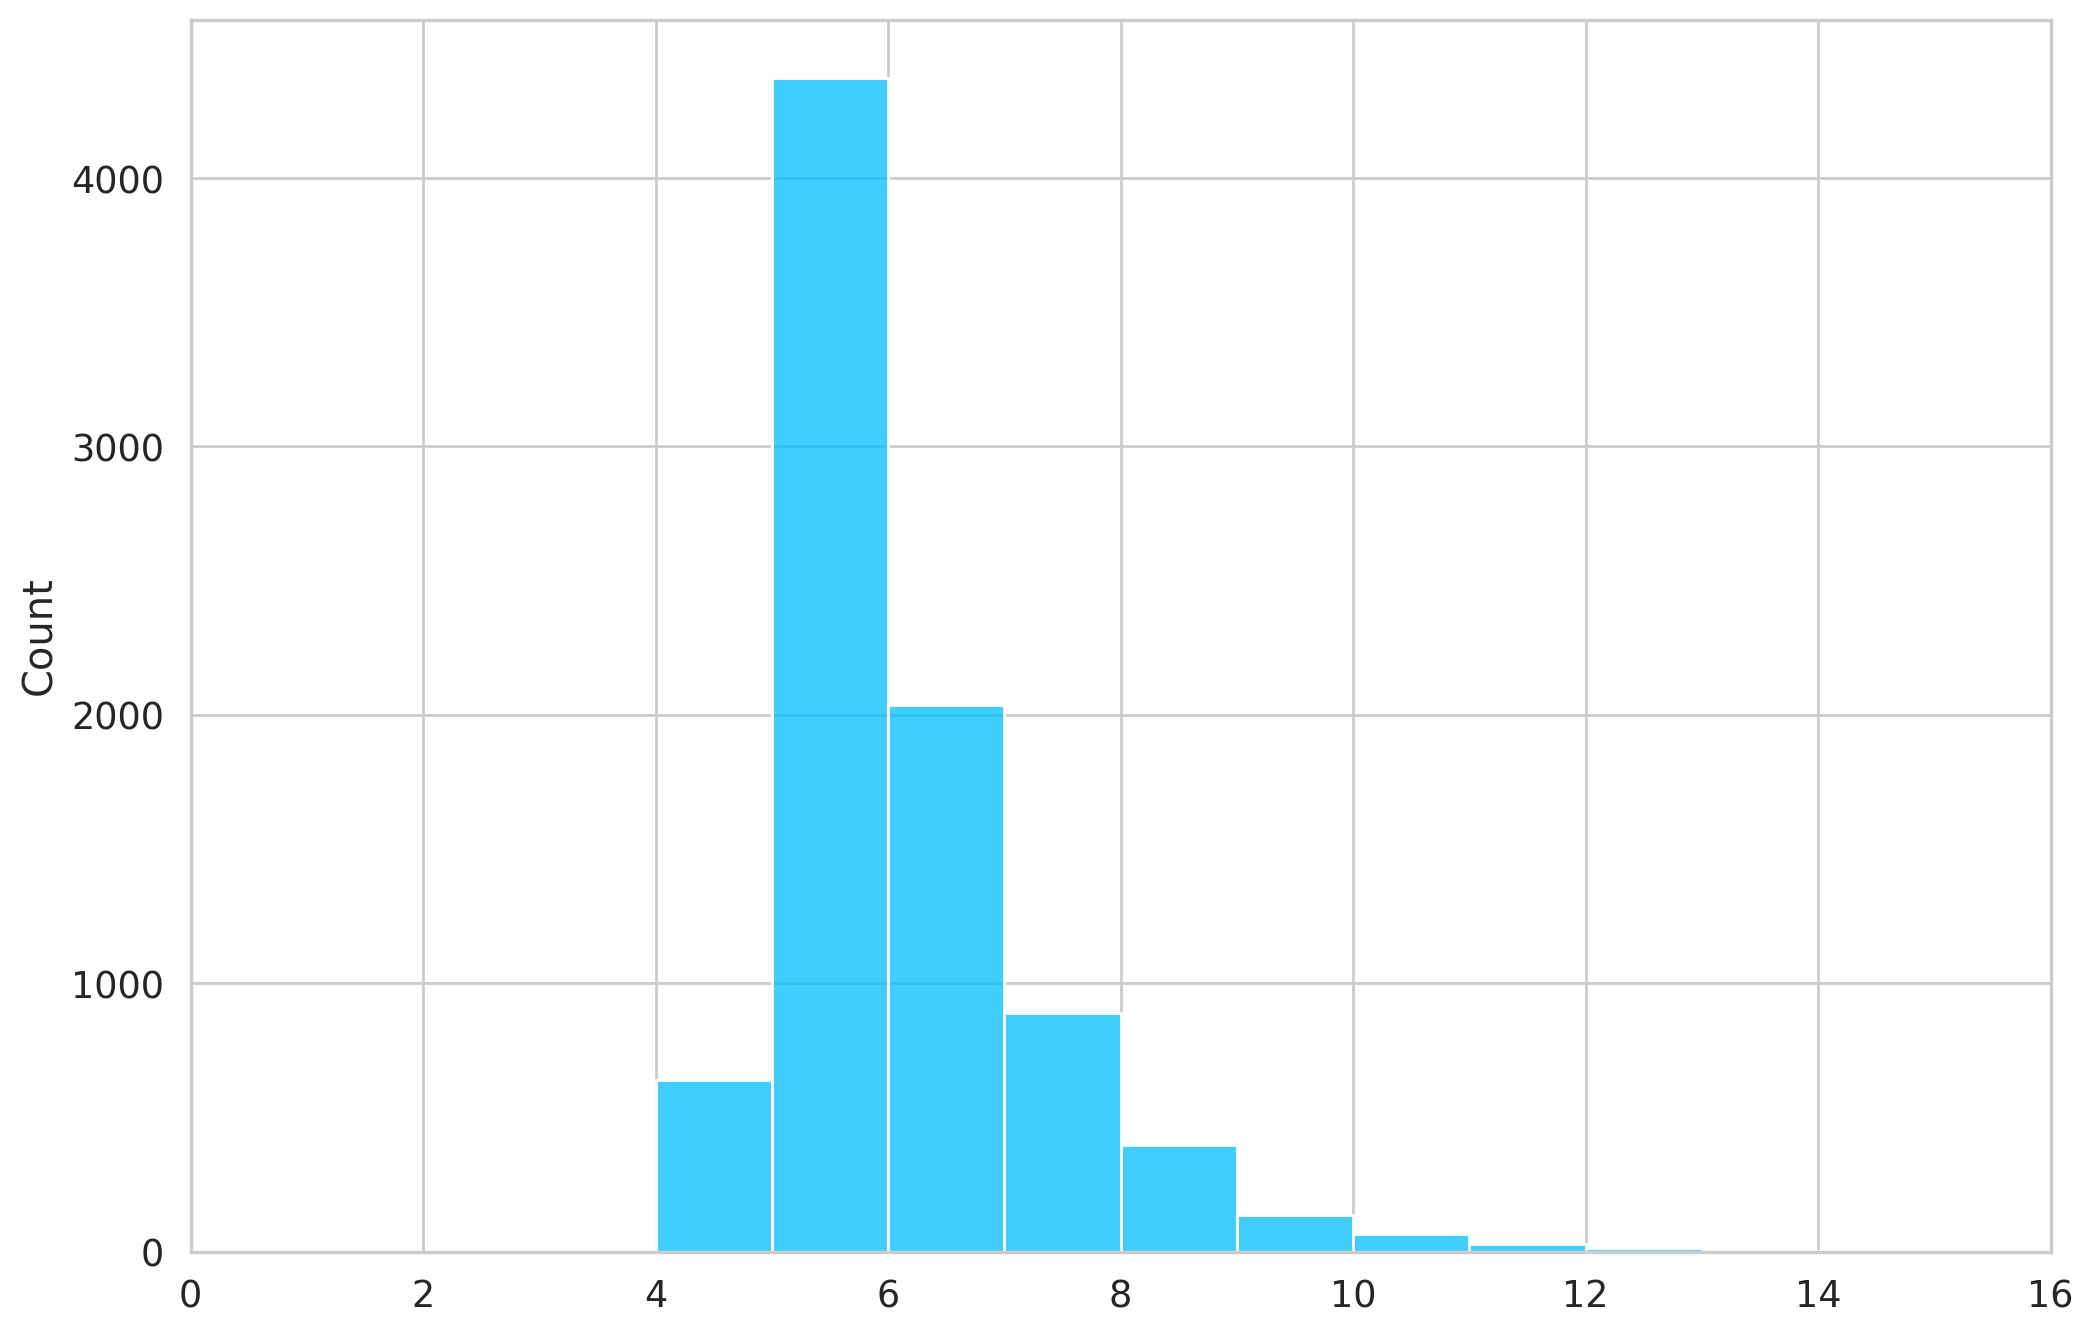

In [ ]:
# Список для хранения количества токенов
token_counts = []

# Итерация по строкам DataFrame
for _, row in data_balans_1.iterrows():
    tokens = tokenizer.encode(
        row["text"],
        max_length=MAX_TOKEN_COUNT,
        truncation=True
    )
    token_count = len(tokens)
    token_counts.append(token_count)
    #print(f"Text: {row['text']}, Tokens: {tokens}, Token Count: {token_count}")

# Построение гистограммы
sns.histplot(token_counts, bins=range(0, MAX_TOKEN_COUNT + 1))
plt.xlim([0, MAX_TOKEN_COUNT])
plt.show()

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
train_df = '/content/data_balanced_train_sentiment_text.csv'
test_df = '/content/data_balanced_train_sentiment_text_2.csv'
val_df = '/content/data_balanced_train_sentiment_text_2.csv'

In [ ]:
# Определите класс ToxicCommentDataModule
class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=64, max_token_len=16):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = CustomDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = CustomDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

In [ ]:
N_EPOCHS = 10

In [ ]:
data_module = ToxicCommentDataModule(train_df, val_df, tokenizer, batch_size=BATCH_SIZE, max_token_len=MAX_TOKEN_COUNT)

In [ ]:
# Вручную вызываем метод setup
data_module.setup()

In [ ]:
class ToxicCommentTagger(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None, log_every_n_steps=30):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

        # self.dropout = nn.Dropout(0.1)  # Добавление слоя Dropout с вероятностью 0.3
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
        self.training_step_outputs = []  # Инициализация атрибута
        self.test_step_outputs = []  # Инициализация атрибута
#------------------------------------------------------------------------------------------------------

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.last_hidden_state[:, 0, :])  # Используем последний скрытый слой

        # output = self.dropout(output.last_hidden_state[:, 0, :])  # Применение Dropout
        # output = self.classifier(output)
        output = torch.sigmoid(output)


        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
            #loss = self.criterion(output.float(), labels.float())  # Преобразование в float
        return loss, output


    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]


        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True, sync_dist=True)
        self.training_step_outputs.append({"labels": labels, "predictions": outputs})  # Добавление выходов в список
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]


        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        #self.training_step_outputs.append({"labels": labels, "predictions": outputs})  # Добавление выходов в список
        return loss


    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]


        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.test_step_outputs.append({"labels": labels, "predictions": outputs})  # Добавление выходов в список
        return loss


    def on_train_epoch_end(self):
        labels = []
        predictions = []

        for output in self.training_step_outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

        #num_labels = len(LABEL_COLUMNS)  # Убедитесь, что num_labels передается корректно
        for i, name in enumerate(LABEL_COLUMNS):

            class_roc_auc = roc_auc_score(labels[:, i], predictions[:, i])
            #class_roc_auc = auroc(predictions[:, i], labels[:, i], task='multilabel', num_classes=num_labels)
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

        self.training_step_outputs.clear()  # Очистка списка после обработки


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )
        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

In [ ]:
# Вычисление количества шагов на эпоху
steps_per_epoch = len(data_module.train_dataset) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = int(total_training_steps * 0.1)  # Пример: 10% шагов для warmup

In [ ]:
total_training_steps

1340

In [ ]:
LABEL_COLUMNS

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

In [ ]:
# # Инициализация модели
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

In [ ]:
# Инициализация логгера
logger = TensorBoardLogger("tb_logs", name="my_model")

# Инициализация early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

# Инициализация checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min")

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    #logger=False,  # Отключение логирования для теста
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    enable_progress_bar=True)  # Включение прогресс-бара

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Перевод модели обратно в режим обучения
model.train()

ToxicCommentTagger(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-1): 2 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type            | Params | Mode 
-------------------------------------------------------
0 | bert       | DistilBertModel | 106 M  | train
1 | classifier | Linear          | 5.4 K  | train
2 | criterion  | BCELoss         | 0      | train
-------------------------------------------------------
106 M     Trainable params
0         Non-trainable params
106 M     Total params
425.552   Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-309-17263e21e0a3>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(labels, dtype=torch.float)
<ipython-input-309-17263e21e0a3>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(labels, dtype=torch.float)
<ipython-input-309-17263e21e0a3>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(labels, dtype=torch.float)


Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-309-17263e21e0a3>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(labels, dtype=torch.float)
<ipython-input-309-17263e21e0a3>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(labels, dtype=torch.float)
<ipython-input-309-17263e21e0a3>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(labels, dtype=torch.float)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 135: 'val_loss' reached 0.40572 (best 0.40572), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


In [ ]:
from torch.utils.data import DataLoader, random_split

train_test_dataset = CustomDataset('/content/data_balanced_train_sentiment_text_2.csv', tokenizer, MAX_TOKEN_COUNT)

test_loader = DataLoader(train_test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Запуск тестирования
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

<ipython-input-215-17263e21e0a3>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(labels, dtype=torch.float)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.36383163928985596    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.36383163928985596}]

In [ ]:
model_tox = ToxicCommentTagger(n_classes=len(LABEL_COLUMNS))

In [ ]:
checkpoint = torch.load('/content/checkpoints/best-checkpoint.ckpt', map_location=torch.device('cpu'))

print(checkpoint.keys())

<ipython-input-265-94bde40dc7aa>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/checkpoints/best-checkpoint.ckpt', map_location=torch.dev

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])


In [ ]:
print(checkpoint['state_dict'].keys())

odict_keys(['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.transformer.layer.0.attention.q_lin.weight', 'bert.transformer.layer.0.attention.q_lin.bias', 'bert.transformer.layer.0.attention.k_lin.weight', 'bert.transformer.layer.0.attention.k_lin.bias', 'bert.transformer.layer.0.attention.v_lin.weight', 'bert.transformer.layer.0.attention.v_lin.bias', 'bert.transformer.layer.0.attention.out_lin.weight', 'bert.transformer.layer.0.attention.out_lin.bias', 'bert.transformer.layer.0.sa_layer_norm.weight', 'bert.transformer.layer.0.sa_layer_norm.bias', 'bert.transformer.layer.0.ffn.lin1.weight', 'bert.transformer.layer.0.ffn.lin1.bias', 'bert.transformer.layer.0.ffn.lin2.weight', 'bert.transformer.layer.0.ffn.lin2.bias', 'bert.transformer.layer.0.output_layer_norm.weight', 'bert.transformer.layer.0.output_layer_norm.bias', 'bert.transformer.layer.1.attention.q_lin.weight', 'be

In [ ]:
model_tox.eval()

ToxicCommentTagger(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-1): 2 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [ ]:
model_tox.freeze()

In [ ]:
# device = torch.device('cpu')  # Используем CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Перемещаем модель на выбранное устройство
model_tox.to(device)

ToxicCommentTagger(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-1): 2 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [ ]:
test_comment = "ты реально пустое место"

In [ ]:
# Encode the test comment
encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)

# Move input tensors to the same device as the model
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

with torch.no_grad():
    _, test_prediction = model_tox(input_ids, attention_mask)


# Convert the prediction to numpy array
test_prediction = test_prediction.flatten().cpu().numpy()


# Print the predictions
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    print(f"{label}: {prediction}")

anger: 0.4531397223472595
disgust: 0.40155190229415894
fear: 0.5342683792114258
joy: 0.5211664438247681
sadness: 0.5301042795181274
surprise: 0.4563114047050476
neutral: 0.5106166005134583


In [ ]:
THRESHOLD = 0.5

In [ ]:
# Encode the test comment
encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)

# Move input tensors to the same device as the model
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

with torch.no_grad():
    _, test_prediction = model_tox(input_ids, attention_mask)
# Convert the prediction to numpy array
test_prediction = test_prediction.flatten().cpu().numpy()

# Print the predictions
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    if prediction < THRESHOLD:
        continue
    print(f"{label}: {prediction}")

fear: 0.5342683792114258
joy: 0.5211664438247681
sadness: 0.5301042795181274
neutral: 0.5106166005134583


In [ ]:
# Определяем функцию для обработки текста
def process_text(text, tokenizer, model_tox, LABEL_COLUMNS, device=device):
    # Кодируем текст
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Перемещаем тензоры на устройство
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Перемещаем модель на устройство
    model_tox.to(device)

    with torch.no_grad():
        _, test_prediction = model_tox(input_ids, attention_mask)

    # Преобразуем предсказание в numpy массив
    test_prediction = test_prediction.flatten().cpu().numpy()

    # Бинаризация предсказаний: если вероятность больше 0.4, то ставим 1, иначе 0
    THRESHOLD = 0.4
    test_prediction = np.where(test_prediction > THRESHOLD, 1, 0)

    # Возвращаем предсказания в виде словаря
    predictions = {label: prediction for label, prediction in zip(LABEL_COLUMNS, test_prediction)}
    return predictions

In [ ]:
test_without_answers = pd.read_csv('/content/valid.csv')
test_without_answers.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,"Это в Новом Орлеане?? Я действительно чувствую, что это Новый Орлеан.",0,0,0,0,0,0,1
1,"Ты знаешь ответ, чувак, ты запрограммирован перехватывать те коды, которые они тебе посылают, не избегай их!",0,0,0,1,0,0,1
2,Мне никогда в жизни не было так грустно!,0,0,0,0,1,0,0
3,"Экономика находится под жестким контролем и субсидируется государством. В любом случае, я тыкал в отсутствии нюансов в сегодняшней политике США.",0,0,0,1,0,0,1
4,"Он мог бы легко взять настоящую камеру из законного источника, изменить цену в Word/Photoshop, а затем распечатать ее.",0,0,0,1,0,0,0


In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
# Применяем функцию к каждой строке в DataFrame
predictions = test_without_answers['text'].progress_apply(lambda x: process_text(x, tokenizer, model_tox, LABEL_COLUMNS))

100%|██████████| 5426/5426 [00:38<00:00, 142.53it/s]


In [ ]:
# Создаем новый DataFrame с предсказаниями
predictions_df = pd.DataFrame(predictions.tolist())

In [ ]:
# Проверяем наличие колонки 'predictions' и объединяем DataFrame
if 'predictions' in test_without_answers.columns:
    result_df = pd.concat([test_without_answers.drop(columns=['predictions']), predictions_df], axis=1)
else:
    result_df = pd.concat([test_without_answers, predictions_df], axis=1)

In [ ]:
result_df.head(5)

,text,anger,disgust,fear,joy,sadness,surprise,neutral,anger,disgust,fear,joy,sadness,surprise,neutral
0,"Это в Новом Орлеане?? Я действительно чувствую, что это Новый Орлеан.",0,0,0,0,0,0,1,1,1,1,1,1,1,1
1,"Ты знаешь ответ, чувак, ты запрограммирован перехватывать те коды, которые они тебе посылают, не избегай их!",0,0,0,1,0,0,1,1,1,1,1,1,1,1
2,Мне никогда в жизни не было так грустно!,0,0,0,0,1,0,0,1,1,1,1,1,1,1
3,"Экономика находится под жестким контролем и субсидируется государством. В любом случае, я тыкал в отсутствии нюансов в сегодняшней политике США.",0,0,0,1,0,0,1,1,1,1,1,1,1,1
4,"Он мог бы легко взять настоящую камеру из законного источника, изменить цену в Word/Photoshop, а затем распечатать ее.",0,0,0,1,0,0,0,1,1,1,1,1,1,1


In [ ]:
y_true = result_df.iloc[:, 1:8].values  # Первые 7 колонок (исключая текст)
y_pred = result_df.iloc[:, 8:].values  # Последние 7 колонок

In [ ]:
# Пример порогового значения
THRESHOLD = 0.4

# Бинаризация предсказаний
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)

In [ ]:
# Расчет метрик классификации
print(classification_report(
    y_true,
    y_pred,
    target_names=LABEL_COLUMNS,
    zero_division=0
))

              precision    recall  f1-score   support

       anger       0.13      1.00      0.23       717
     disgust       0.02      0.99      0.04        97
        fear       0.02      1.00      0.04       105
         joy       0.41      1.00      0.58      2219
     sadness       0.07      1.00      0.13       390
    surprise       0.12      1.00      0.21       624
     neutral       0.33      1.00      0.49      1766

   micro avg       0.16      1.00      0.27      5918
   macro avg       0.16      1.00      0.25      5918
weighted avg       0.28      1.00      0.42      5918
 samples avg       0.16      1.00      0.27      5918

